<a href="https://colab.research.google.com/github/isabellacadisco/I-hate-you-P7-/blob/main/P7_textsent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets evaluate accelerate
!pip install optuna
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 24.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (4

In [24]:
from datasets import load_dataset
from datasets.dataset_dict import DatasetDict
import evaluate

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback
from transformers.utils import logging
from transformers import EarlyStoppingCallback
from transformers import pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
from copy import deepcopy
import shap

In [3]:
# To read the data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_en = '/content/drive/MyDrive/misoginy_det/final_labels.csv'

data_en = load_dataset("csv", data_files=path_en)

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
data_en = data_en.remove_columns(['entry_id', 'link_id', 'parent_id', 'entry_utc', 'subreddit', 'author', 'image', 'label_date', 'week', 'group', 'sheet_order', 'level_2', 'level_3', 'strength', 'highlight'])

In [6]:
len(data_en['train'])

6567

train, validation test split

In [7]:
val_test = data_en.filter(lambda example: example['split'] == 'test').remove_columns(['split'])['train'].train_test_split(test_size=0.5, seed=42)

Filter:   0%|          | 0/6567 [00:00<?, ? examples/s]

In [8]:
ds = DatasetDict({
    'train': data_en.filter(lambda example: example['split'] == 'train').remove_columns(['split'])['train'],
    'validation': val_test['train'],
    'test' : val_test['test']

})

Filter:   0%|          | 0/6567 [00:00<?, ? examples/s]

In [9]:
ds = ds.rename_column("level_1", "label")

In [10]:
ds

DatasetDict({
    train: Dataset({
        features: ['body', 'label'],
        num_rows: 5264
    })
    validation: Dataset({
        features: ['body', 'label'],
        num_rows: 651
    })
    test: Dataset({
        features: ['body', 'label'],
        num_rows: 652
    })
})

In [11]:
ds['train'][0]

{'body': 'Do you have the skin of a 80 year old grandma? Worry no more, just drink water!',
 'label': 'Nonmisogynistic'}

remove null rows

In [12]:
def remove_none_rows(example):
    return example["body"] is not None

ds = ds.filter(remove_none_rows)

Filter:   0%|          | 0/5264 [00:00<?, ? examples/s]

Filter:   0%|          | 0/651 [00:00<?, ? examples/s]

Filter:   0%|          | 0/652 [00:00<?, ? examples/s]

In [13]:
ds

DatasetDict({
    train: Dataset({
        features: ['body', 'label'],
        num_rows: 5254
    })
    validation: Dataset({
        features: ['body', 'label'],
        num_rows: 651
    })
    test: Dataset({
        features: ['body', 'label'],
        num_rows: 650
    })
})

In [18]:
pd_train = ds['train'].to_pandas()
pd_validation = ds['validation'].to_pandas()
pd_test = ds['test'].to_pandas()

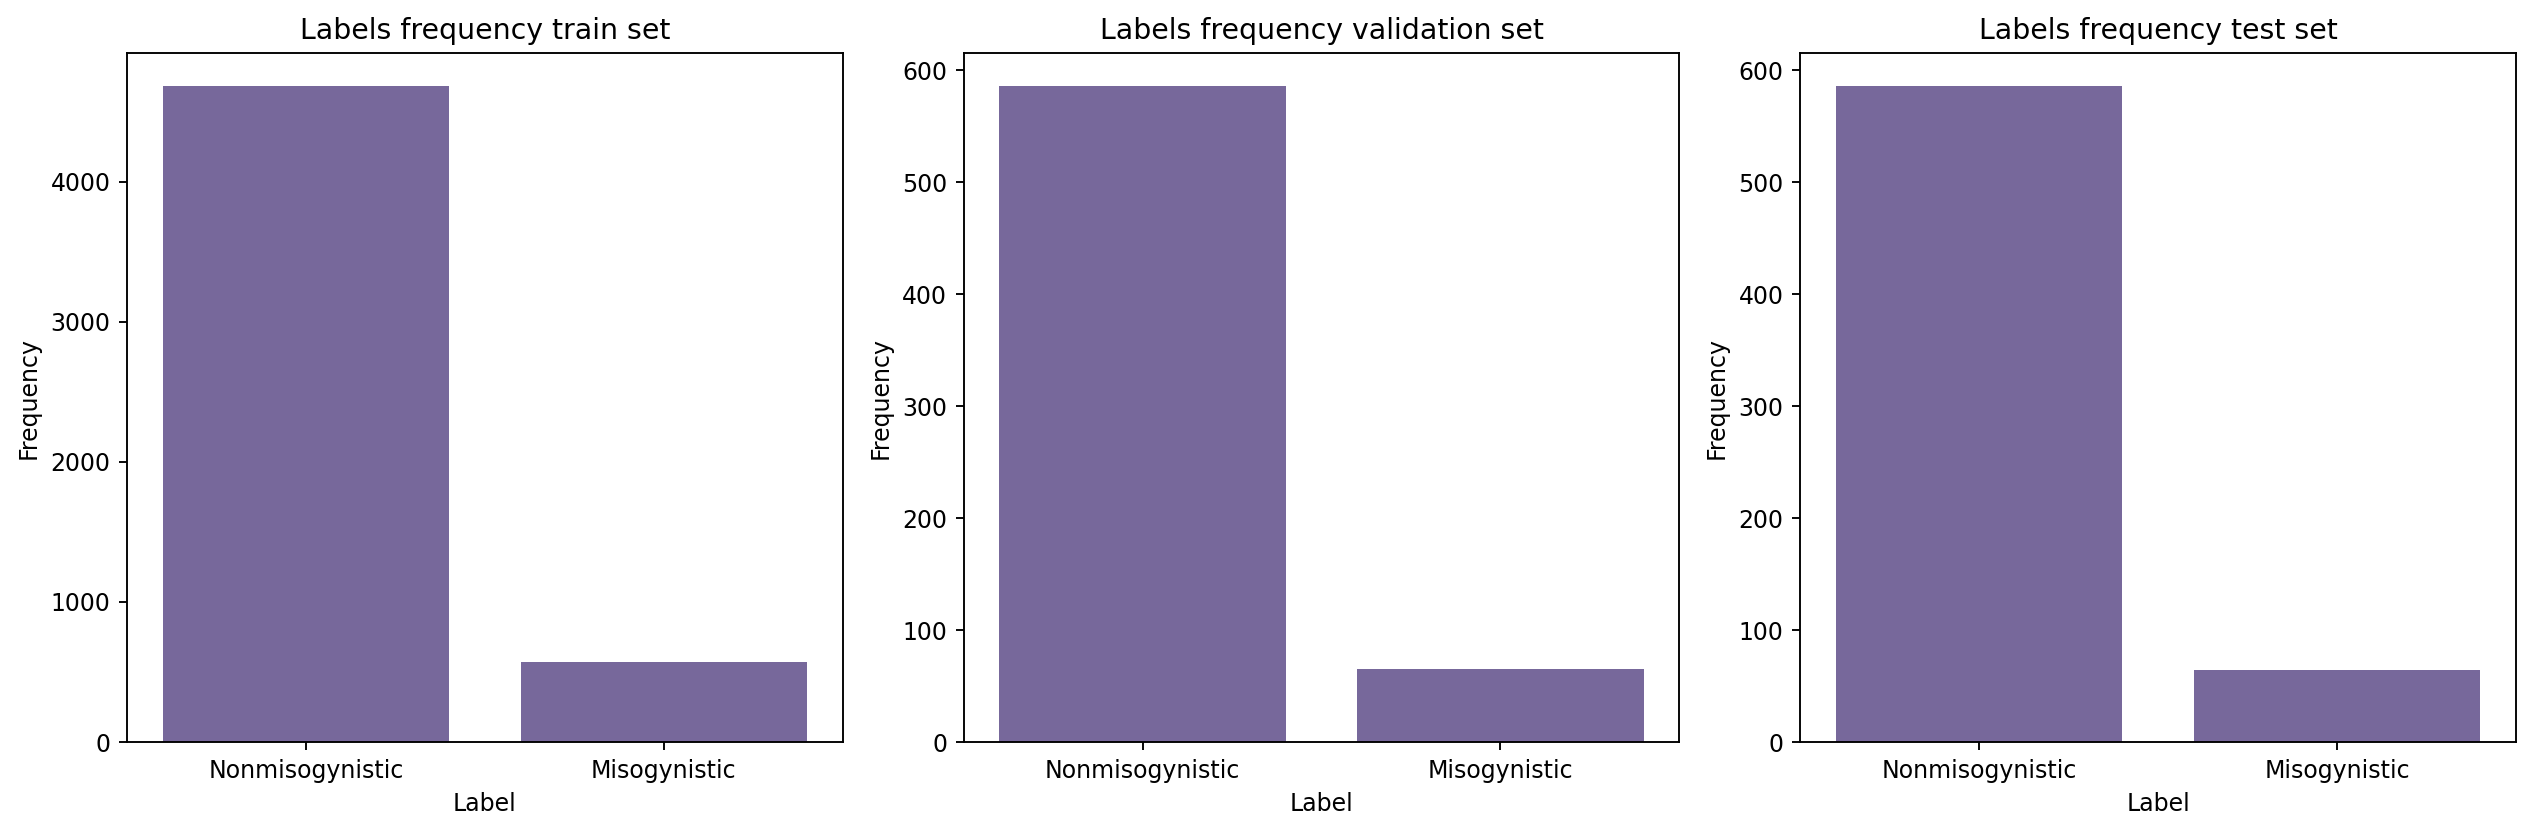

In [21]:
plt.figure(figsize=(15, 5),dpi =170)

# Plot for pd_train
plt.subplot(1, 3, 1)
sns.countplot(data=pd_train, x='label', color = "#7360a3")
plt.title('Labels frequency train set')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Plot for pd_validation
plt.subplot(1, 3, 2)
sns.countplot(data=pd_validation, x='label', color = "#7360a3")
plt.title('Labels frequency validation set')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Plot for pd_test
plt.subplot(1, 3, 3)
sns.countplot(data=pd_test, x='label', color = "#7360a3")
plt.title('Labels frequency test set')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

distilbert fine tuning

In [34]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
tokenizer(ds['train'][0]['body'])

{'input_ids': [101, 2079, 2017, 2031, 1996, 3096, 1997, 1037, 3770, 2095, 2214, 13055, 1029, 4737, 2053, 2062, 1010, 2074, 4392, 2300, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [35]:
def preprocess_function(examples):
    return tokenizer(examples['body'], truncation=True, padding='max_length', max_length=512)

In [36]:
tokenized = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/5254 [00:00<?, ? examples/s]

Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/650 [00:00<?, ? examples/s]

In [37]:
tokenized

DatasetDict({
    train: Dataset({
        features: ['body', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5254
    })
    validation: Dataset({
        features: ['body', 'label', 'input_ids', 'attention_mask'],
        num_rows: 651
    })
    test: Dataset({
        features: ['body', 'label', 'input_ids', 'attention_mask'],
        num_rows: 650
    })
})

Woah woah woah woah woah fuckin woah... Isn't that dude entitled to that money because of all the "unpaid labour" he did as a house-husband? That's how it works, right?

In [ ]:
#tokenized['test'][19]['body']

tokenized['test'][377]['body']

'I would say you have three possible options. Rookie, intermediate, and advanced. Which option you choose is strictly up to your level of confidence. \n\nRookie: pick her up from work and when you see the guy, just give him a stare. Say nothing. Give him a handshake and crush his hand during the handshake. Say "is this the fat faggot you were telling me about?" This path is a little insecure but if fatty is a pussy he will fuck off\n\nIntermediate: Go thru her phone next time you see her. Search all apps, search her texts with keywords, social media. See if there\'s any communication between them. If there is, hard next the bitch. \n\nAdvanced: Tell her you don\'t care. Ignore the issue completely. Work on yourself, lift, talk to other girls. Make friends with other girls. Don\'t tell her about them but let her see that the cashier at the store finds you attractive. Subconsciously it will fuck with her big time. If she is chasing your validation she won\'t give a fuck about her faggy c

In [38]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [39]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

print(accuracy.description)
print(f1.description)
print(precision.description)
print(recall.description)


Accuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
 Where:
TP: True positive
TN: True negative
FP: False positive
FN: False negative


The F1 score is the harmonic mean of the precision and recall. It can be computed with the equation:
F1 = 2 * (precision * recall) / (precision + recall)


Precision is the fraction of correctly labeled positive examples out of all of the examples that were labeled as positive. It is computed via the equation:
Precision = TP / (TP + FP)
where TP is the True positives (i.e. the examples correctly labeled as positive) and FP is the False positive examples (i.e. the examples incorrectly labeled as positive).


Recall is the fraction of the positive examples that were correctly labeled by the model as positive. It can be computed with the equation:
Recall = TP / (TP + FN)
Where TP is the true positives and FN is the false negatives.



In [40]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # compute
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)
    f1_value = f1.compute(predictions=predictions, references=labels)
    precision_value = precision.compute(predictions=predictions, references=labels)
    recall_value = recall.compute(predictions=predictions, references=labels)

    # return metrics as dict
    return {
        "accuracy": accuracy_value['accuracy'],
        "f1": f1_value['f1'],
        "precision": precision_value['precision'],
        "recall": recall_value['recall']
    }


In [41]:
id2label = {0: "Nonmisogynistic", 1: "Misogynistic"}
label2id = {"Nonmisogynistic": 0, "Misogynistic": 1}

early stopping

In [26]:
logger = logging.get_logger(__name__)

In [27]:
class Custom_EarlyStoppingCallback(EarlyStoppingCallback):

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        metric_to_check = args.metric_for_best_model
        if not metric_to_check.startswith("eval_"):
            metric_to_check = f"eval_{metric_to_check}"
        metric_value = metrics.get(metric_to_check)

        if metric_value is None:
            logger.warning(
                f"early stopping required metric_for_best_model, but did not find {metric_to_check} so early stopping"
                " is disabled"
            )
            return

        self.check_metric_value(args, state, control, metric_value)
        if self.early_stopping_patience_counter >= self.early_stopping_patience:
            print('EARLY STOPPING CALLED!')
            control.should_training_stop = True

hyperparameters optimization
- learning rate

In [28]:
def compute_objective_recall(metrics):
    """
    The default objective to maximize/minimize when doing an hyperparameter search. It is the evaluation loss if no
    metrics are provided to the [`Trainer`], the sum of all metrics otherwise.

    Args:
        metrics (`Dict[str, float]`): The metrics returned by the evaluate method.

    Return:
        `float`: The objective to minimize or maximize
    """
    metrics = copy.deepcopy(metrics)
    loss = metrics.pop("eval_loss", None)
    _ = metrics.pop("epoch", None)
    # Remove speed metrics
    speed_metrics = [
        m
        for m in metrics.keys()
        if m.endswith("_runtime") or m.endswith("_per_second") or m.endswith("_compilation_time")
    ]
    for sm in speed_metrics:
        _ = metrics.pop(sm, None)
    return loss if len(metrics) == 0 else metrics['eval_recall']

In [ ]:
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
    }

In [ ]:
def model_init(trial):
    return AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/misoginy_det",

    num_train_epochs=12,

    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model = 'eval_recall', # avoid FN
    load_best_model_at_end=True,
    push_to_hub=False,

    logging_first_step=True,
    fp16=True,
    auto_find_batch_size=True,
)


In [43]:
# convert labels from string to 0,1
def convert_labels(example):
    example['label'] = label2id[example['label']]
    return example

converted = tokenized.map(convert_labels)


Map:   0%|          | 0/5254 [00:00<?, ? examples/s]

Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/650 [00:00<?, ? examples/s]

In [ ]:
trainer = Trainer(
    model=None,
    args=training_args,
    train_dataset=converted['train'],
    eval_dataset=converted['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    model_init=model_init,
    data_collator=data_collator,
    callbacks = [Custom_EarlyStoppingCallback(early_stopping_patience=2,
                                              early_stopping_threshold=0.01)]
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
best_trials = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=3,
    compute_objective=compute_objective_recall,
)

[I 2024-05-05 15:24:53,062] A new study created in memory with name: no-name-d2893f5b-d311-4d2b-92cd-d81d66d06e94
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EARLY STOPPING CALLED!


[I 2024-05-05 15:36:22,210] Trial 0 finished with value: 0.4307692307692308 and parameters: {'learning_rate': 2.8700021896396337e-05}. Best is trial 0 with value: 0.4307692307692308.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EARLY STOPPING CALLED!


[I 2024-05-05 15:45:56,892] Trial 1 finished with value: 0.46153846153846156 and parameters: {'learning_rate': 8.79483022891657e-05}. Best is trial 1 with value: 0.46153846153846156.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EARLY STOPPING CALLED!


[I 2024-05-05 15:55:38,917] Trial 2 finished with value: 0.49230769230769234 and parameters: {'learning_rate': 1.4644970779446607e-05}. Best is trial 2 with value: 0.49230769230769234.


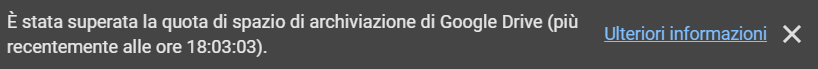

In [ ]:
best_trials

BestRun(run_id='2', objective=0.49230769230769234, hyperparameters={'learning_rate': 1.4644970779446607e-05}, run_summary=None)

train a model with best learning rate selected via HPO, but add weight_decay = 0.01 to try to prevent overfitting

In [29]:
args_best = TrainingArguments(
    output_dir="/content/drive/MyDrive/misoginy_det/best_model",

    num_train_epochs=12,
    weight_decay = 0.01,
    learning_rate = 1.5e-5,

    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model = 'eval_recall', # bavoid FN
    load_best_model_at_end=True,
    push_to_hub=False,

    logging_first_step=True,
    fp16=True,
    auto_find_batch_size=True,
)


In [32]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
trainer_best = Trainer(
    model=model,
    args=args_best,
    train_dataset=converted['train'],
    eval_dataset=converted['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks = [Custom_EarlyStoppingCallback(early_stopping_patience=2,
                                              early_stopping_threshold=0.01)]
)

In [ ]:
train_best_results = trainer_best.train()

EARLY STOPPING CALLED!


In [ ]:
trainer_best.save_model('/content/drive/MyDrive/misoginy_det/best_model/model')

In [ ]:
trainer_best.evaluate()

EARLY STOPPING CALLED!


{'eval_loss': 0.36658382415771484,
 'eval_accuracy': 0.9262672811059908,
 'eval_f1': 0.625,
 'eval_precision': 0.6349206349206349,
 'eval_recall': 0.6153846153846154,
 'eval_runtime': 4.5683,
 'eval_samples_per_second': 142.504,
 'eval_steps_per_second': 17.95,
 'epoch': 5.0}

In [ ]:
predictions = trainer_best.predict(converted['test'])

In [ ]:
predictions

PredictionOutput(predictions=array([[ 3.8417969, -3.6621094],
       [ 3.8457031, -3.6191406],
       [ 3.8125   , -3.7246094],
       ...,
       [ 3.9492188, -3.7636719],
       [ 1.828125 , -1.7451172],
       [ 3.7050781, -3.4628906]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    

In [ ]:
predicted_labels = np.argmax(predictions.predictions, axis=1)
ground_truth_labels = predictions.label_ids

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def print_confusion_matrix(predictions, labels):

    cm = confusion_matrix(labels, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-misogynistic", "Misogynistic"],
                yticklabels=["Non-misogynistic", "Misogynistic"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


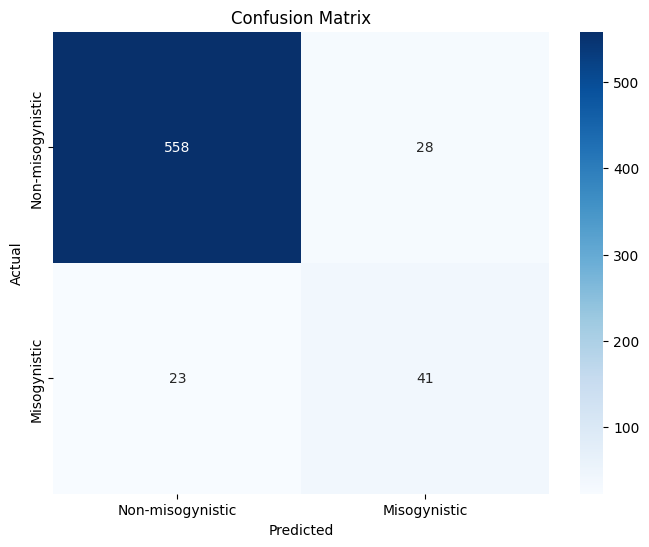

In [ ]:
print_confusion_matrix(predicted_labels, ground_truth_labels)

In [ ]:
def print_confusion_matrix_normalize(predictions, labels):

    cm = confusion_matrix(labels, predictions, normalize="true")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["Non-misogynistic", "Misogynistic"],
                yticklabels=["Non-misogynistic", "Misogynistic"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


from the confusion matrix is possible to see that the misogynistic tweets classified as non misogynistic are 0.36, 23 of 64

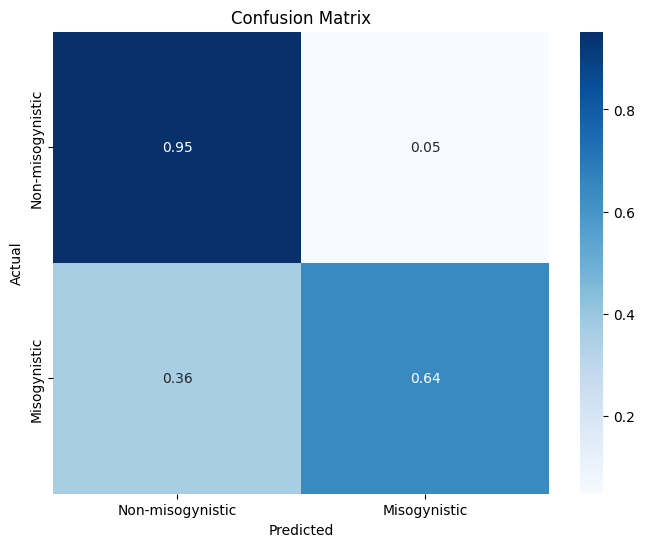

In [ ]:
print_confusion_matrix_normalize(predicted_labels, ground_truth_labels)

## Shap explanation

In [45]:
torch.cuda.empty_cache()

In [46]:
best_model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/misoginy_det/best_model/model',
    id2label=id2label,
    label2id=label2id,).cuda()

In [50]:
# build a pipeline object to do predictions
pred = pipeline(
    "text-classification",
    model=best_model,
    tokenizer=tokenizer,
    device=0,
    top_k=None,
)

In [51]:
explainer = shap.Explainer(pred)

In [66]:
data_shap = ds['test']
data_shap = data_shap.rename_column("body", "text")
data_shap

Dataset({
    features: ['text', 'label'],
    num_rows: 650
})

Since I am interested in the lessical explanation for a text being classified as misogynistic, i will consider only the ones belonging to this category.


In [67]:
mis_shap_data = data_shap.filter(lambda ex: ex['label'] == 'Misogynistic')

In [68]:
mis_shap_data

Dataset({
    features: ['text', 'label'],
    num_rows: 64
})

In [69]:
# get indices of text <= 512 tokens
def f(x):
    tokenized_texts = [
        tokenizer.encode(v, max_length=512, truncation=True) if len(v) <= 512 else []
        for v in x
    ]

    valid_indices = [i for i, tokens in enumerate(tokenized_texts) if tokens]
    return valid_indices

In [71]:
valid_indices = f(mis_shap_data['text'])

In [73]:
len(valid_indices)

40

In [62]:
# put text in lower case
mis_shap_data_lower = mis_shap_data.map(lambda example: {'text': example['text'].lower(), 'label': example['label']})


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

In [76]:
shap_values = explainer(mis_shap_data_lower[valid_indices])

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 41it [02:19,  3.57s/it]


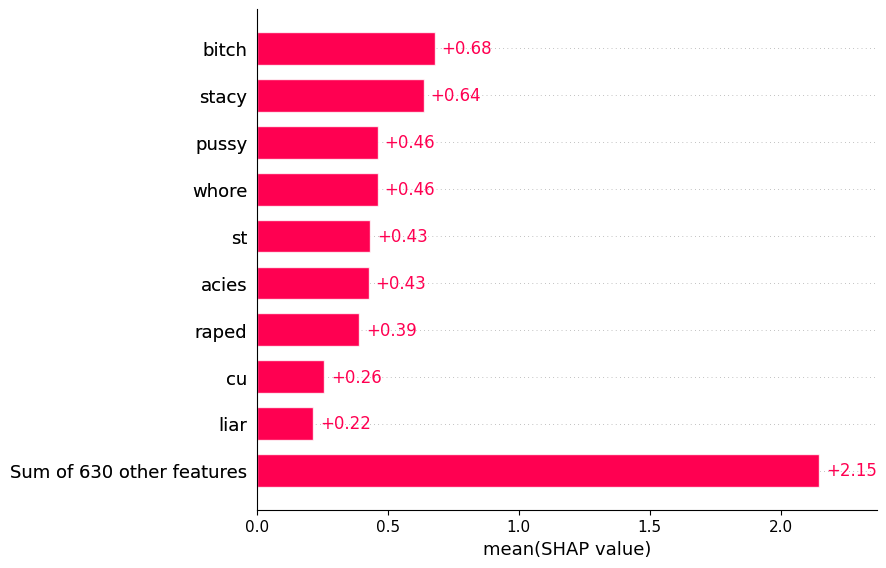

In [77]:
shap.plots.bar(shap_values[:, :, "Misogynistic"].mean(0))

In [81]:
shap.plots.text(shap_values[:, :, "Misogynistic"])